In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS

In [8]:
# 1. 读入三张表
daily = pd.read_csv("daily_post_data.csv", parse_dates=["date"])
pb    = pd.read_csv("pb_ratio_data.csv",    parse_dates=["date"])
sd    = pd.read_csv("start_date_data.csv",  parse_dates=["start_date","end_date"])

# 重命名上市/退市字段
sd = sd.rename(columns={
    "start_date": "list_date",
    "end_date":   "delist_date"
})

# 2. 计算日收益率
daily = daily.sort_values(["code","date"])
daily["ret"]     = daily.groupby("code")["close"].pct_change()
daily = daily.dropna(subset=["ret"])

# 3. 合并上市/退市日期，剔除上市未满 3 个月、已退市、停牌的记录
daily = daily.merge(sd[["code","list_date","delist_date"]], on="code", how="left")
daily = daily[
    (daily["date"] >= daily["list_date"] + pd.DateOffset(months=3)) &
    (daily["date"] <= daily["delist_date"]) &
    (~daily["paused"])
].copy()

# 4. 标注月份和月末交易日
# 确保 date 是 datetime 类型
daily['date'] = pd.to_datetime(daily['date'])
daily["month"] = daily["date"].dt.to_period("M")
month_ends = (
    daily.groupby("month")["date"]
         .max()
         .reset_index()
         .rename(columns={"date":"month_end"})
)

# 5. 月度特征：PB（当月末取最近一次），上月累积收益（用于 MOM）
pb["month"] = pb["date"].dt.to_period("M")
pb_m = (
    pb.groupby(["code","month"])["pb_ratio"]
      .last()
      .reset_index()
)

# 5.1 计算每只股票每月累计收益
month_ret = (
    daily.groupby(["code","month"])["ret"]
         .apply(lambda x: (1 + x).prod() - 1)
         .reset_index(name="month_ret")
)

# 6. 构建月末截面表
# ========= 6. 构造月末截面并带上 month =========
# daily 已经有 date、month、circulating_market_cap
# month_ends 有 month_end

m = (
    daily
    # 先把月末交易日标进来
    .merge(month_ends[['month_end']], 
           left_on='date', right_on='month_end', how='inner')
    # 现在只有 date == month_end 的那几天
    # 重新自己做 month（Period 类型）
    .assign(month=lambda df: df['date'].dt.to_period('M'))
    # 只留我们后面要用的列
    [['code','month','date','circulating_market_cap']]
    # 合并 PB 和 月度收益
    .merge(pb_m,      on=['code','month'], how='left')
    .merge(month_ret, on=['code','month'], how='left')
    .dropna(subset=['circulating_market_cap','pb_ratio','month_ret'])
)

# 7. 滚动构建因子：对每个 month_end，选样本、分组、算日度因子收益
factor_list = []
for _, row in month_ends.iterrows():
    me = row['month_end']
    nm = me + pd.offsets.MonthEnd(1)

    # 当期月末截面
    uni = m[m['date']==me].copy()
    n   = len(uni)
    # 分组选 code 列表……
    small = uni.nsmallest(n//3, 'circulating_market_cap')['code']
    large = uni.nlargest(n//3, 'circulating_market_cap')['code']
    lowpb = uni.nsmallest(n//3, 'pb_ratio')['code']
    hipb  = uni.nlargest(n//3, 'pb_ratio')['code']
    losers= uni.nsmallest(n//3, 'month_ret')['code']
    wins  = uni.nlargest(n//3, 'month_ret')['code']

    # 下月日度样本
    nxt = daily[(daily['date']>me) & (daily['date']<=nm)]
    w   = uni.set_index('code')['circulating_market_cap']

    def port_ret(codes):
        sub = nxt[nxt['code'].isin(codes)]
        return (sub['ret'] * sub['code'].map(w)).groupby(sub['date']).sum() / w[codes].sum()

    mkt = port_ret(uni['code'])
    smb = port_ret(small) - port_ret(large)
    hml = port_ret(lowpb)  - port_ret(hipb)
    mom = port_ret(losers) - port_ret(wins)

    df = pd.DataFrame({
        'date': mkt.index,
        'MKT':  mkt.values,
        'SMB':  smb.values,
        'HML':  hml.values,
        'MOM':  mom.values
    })
    factor_list.append(df)

# 8. 合并成完整的日度因子序列
factors = pd.concat(factor_list).sort_values("date").reset_index(drop=True)

# 结果预览
print(factors.head())

        date       MKT       SMB       HML       MOM
0 2021-01-04  0.013270 -0.001547 -0.025641 -0.012514
1 2021-01-05  0.010642 -0.017938 -0.031508 -0.018632
2 2021-01-06  0.003316 -0.025149  0.004367 -0.019419
3 2021-01-07  0.004709 -0.047980 -0.016925 -0.043243
4 2021-01-08 -0.001985  0.000535  0.017457  0.022528


In [9]:
#合并
df = (
    daily[['code','date','ret']]
    .merge(factors, on='date', how='inner')
    .sort_values(['code','date'])
    .reset_index(drop=True)
)


In [10]:
window = 21
resid_frames = []

# 按股票代码分组滚动回归
for code, grp in df.groupby('code', group_keys=False):
    grp = grp.sort_values('date').set_index('date')
    if len(grp) < window:
        continue

    # 构造自变量和因变量
    X = sm.add_constant(grp[['MKT', 'SMB', 'HML', 'MOM']])
    y = grp['ret']

    # 执行滚动回归
    rol = RollingOLS(endog=y, exog=X, window=window)
    rres = rol.fit()

    # 1. 提取回归系数（每期一个 beta 向量）
    betas = rres.params  # DataFrame: index=date, columns=['const','MKT','SMB','HML','MOM']

    # 2. 构造对应设计矩阵
    X_design = sm.add_constant(grp[['MKT', 'SMB', 'HML', 'MOM']])

    # 3. 计算拟合值（注意两个 DataFrame 要 index 对齐）
    fitted = (betas * X_design).sum(axis=1)

    # 4. 计算残差
    resid = (grp['ret'] - fitted).rename('residual')

    # 5. 重置索引，加上 code
    res = resid.reset_index()
    res['code'] = code

    # 6. 丢掉前 window-1 个 NaN
    res = res.iloc[window:]

    resid_frames.append(res[['code', 'date', 'residual']])

# 合并所有股票结果
resid_df = pd.concat(resid_frames, ignore_index=True)
print(resid_df.head())

          code       date  residual
0  000001.XSHE 2021-04-02  0.021294
1  000001.XSHE 2021-04-06 -0.018439
2  000001.XSHE 2021-04-07 -0.025984
3  000001.XSHE 2021-04-08 -0.000965
4  000001.XSHE 2021-04-09 -0.019951


In [11]:

# 设定窗口长度和一年交易日
window = 21
T      = 243

# 先按 code 排序
resid_df = resid_df.sort_values(['code','date'])

# 1. 用滚动 window 计算残差的样本标准差
rolling_std = (
    resid_df
      .groupby('code')['residual']
      .rolling(window, min_periods=window)
      .std()
      .reset_index(level=0, drop=True)
)

# 2. 年化：乘以 sqrt(T)
resid_df['IVCARHART'] = rolling_std * np.sqrt(T)

# 3. 看一下
print(resid_df[['code','date','residual','IVCARHART']].head(10))


          code       date  residual  IVCARHART
0  000001.XSHE 2021-04-02  0.021294        NaN
1  000001.XSHE 2021-04-06 -0.018439        NaN
2  000001.XSHE 2021-04-07 -0.025984        NaN
3  000001.XSHE 2021-04-08 -0.000965        NaN
4  000001.XSHE 2021-04-09 -0.019951        NaN
5  000001.XSHE 2021-04-12 -0.018828        NaN
6  000001.XSHE 2021-04-13  0.012262        NaN
7  000001.XSHE 2021-04-14 -0.020599        NaN
8  000001.XSHE 2021-04-15 -0.013208        NaN
9  000001.XSHE 2021-04-16 -0.018673        NaN


           code       date  residual  IVCARHART
20  000001.XSHE 2021-05-06  0.016829   0.312659
21  000001.XSHE 2021-05-07  0.012791   0.306640
22  000001.XSHE 2021-05-10 -0.011039   0.302592
23  000001.XSHE 2021-05-11 -0.020474   0.297570
24  000001.XSHE 2021-05-12 -0.000046   0.297572


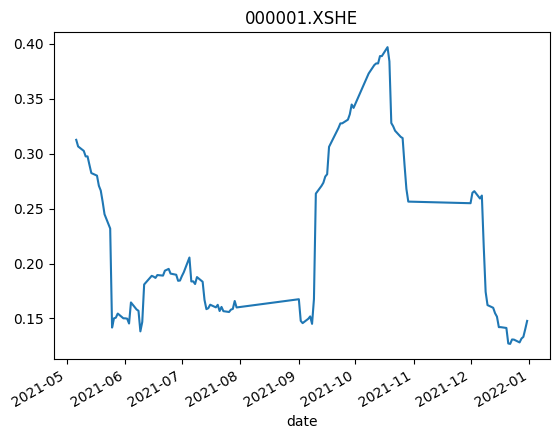

In [12]:
# 看看什么时候第一个非 NaN 出现
print(resid_df[resid_df["IVCARHART"].notnull()].head())

# 画一下每只票的 IVCARHART
for code, grp in resid_df.groupby("code"):
    grp.set_index("date")["IVCARHART"].dropna().plot(title=code)
    break
plt.show()


In [19]:
# 参数
n_group      = 10           # 分 10 组
fee_rate     = 0.003        # 双边千3，总成本 0.3%
trade_cost   = fee_rate     # 直接把换手率 * fee_rate 作为交易成本
long_q       = 10            # 做多第 1 组
short_q      = 1      # 做空第 10 组

# 1. 计算 VWAP
daily['vwap'] = daily['money'] / daily['volume']

# 2. 把因子和价格合并
dfb = pd.merge(
    resid_df[['code','date','IVCARHART']],
    daily[['code','date','vwap']],
    on=['code','date'], how='left'
).dropna(subset=['IVCARHART','vwap'])

# 3. 取所有调仓日（因为是“每日调仓”就用所有因子出现的日期）
trade_dates = sorted(dfb['date'].unique())

# 用来存结果
results = []
prev_weights = {}  # 上一日的仓位表：code -> weight

for i in range(len(trade_dates)-1):
    t  = trade_dates[i]
    t1 = trade_dates[i+1]

    # 当日所有股票的因子值
    fdf = dfb[dfb['date']==t].copy()

    # 分组：1–10 组
    fdf['group'] = pd.qcut(fdf['IVCARHART'],
                           q=n_group,
                           labels=False) + 1

    # 确定做多 / 做空名单
    long_codes  = fdf[fdf['group']== long_q]['code'].tolist()
    short_codes = fdf[fdf['group']== short_q]['code'].tolist()

    # 等权仓位
    w_long  = 1.0 / len(long_codes)  if long_codes  else 0.0
    w_short = -1.0/ len(short_codes) if short_codes else 0.0

    curr_weights = {c:w_long  for c in long_codes}
    curr_weights.update({c:w_short for c in short_codes})

    # 计算换手率 = Σ|w_t - w_{t-1}| / 2
    all_codes = set(prev_weights) | set(curr_weights)
    turnover = sum(abs(curr_weights.get(c,0)-prev_weights.get(c,0))
                   for c in all_codes) / 2

    prev_weights = curr_weights

    # 取当日和次日 VWAP 计算单只股收益
    pv = daily.set_index(['code','date'])['vwap']
    pre_fee_rets = []
    for code in long_codes + short_codes:
        p0 = pv.get((code,t), np.nan)
        p1 = pv.get((code,t1),np.nan)
        if pd.notna(p0) and pd.notna(p1):
            pre_fee_rets.append((p1/p0 - 1) * curr_weights[code])
    pre_fee = sum(pre_fee_rets)

    # 扣成本
    post_fee = pre_fee - turnover * trade_cost

    results.append({
        'date':        t,
        'pre_fee_ret': pre_fee,
        'post_fee_ret':post_fee,
        'turnover':     turnover
    })

# 4. 汇总结果
backtest_df = pd.DataFrame(results)
print(backtest_df.head())


        date  pre_fee_ret  post_fee_ret  turnover
0 2021-05-06    -0.002562     -0.005562  1.000000
1 2021-05-07     0.011493      0.010957  0.178841
2 2021-05-10     0.004586      0.004134  0.150754
3 2021-05-11     0.004926      0.004428  0.165829
4 2021-05-12     0.008779      0.008311  0.155779


<Axes: title={'center': 'Decile-based equal-weighted cumulative return'}, xlabel='Date', ylabel='Cumulative Return'>

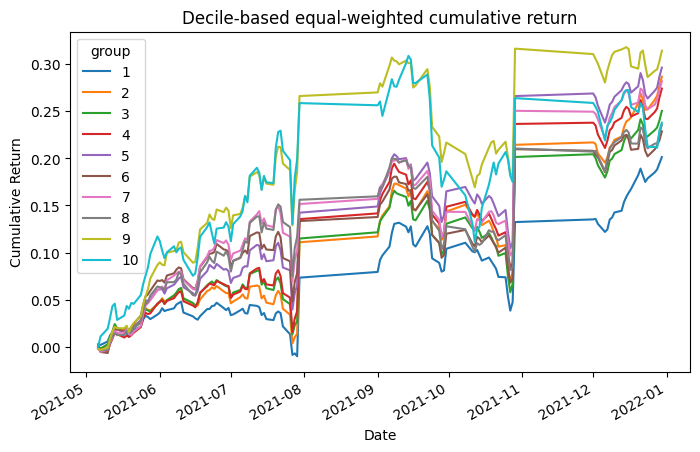

In [23]:
# 先把 daily 的 vwap 做成 lookup
pv = daily.set_index(['code','date'])['vwap']

group_returns = []
for i in range(len(trade_dates)-1):
    t  = trade_dates[i]
    t1 = trade_dates[i+1]
    fdf = dfb[dfb['date']==t].copy()
    # 1) 分组
    fdf['group'] = pd.qcut(fdf['IVCARHART'], q=n_group, labels=False) + 1

    # 2) 对每个组算下当日持仓到次日的等权收益
    for g in range(1, n_group+1):
        codes = fdf[fdf['group']==g]['code'].tolist()
        rets = []
        for code in codes:
            p0 = pv.get((code,t), np.nan)
            p1 = pv.get((code,t1),np.nan)
            if pd.notna(p0) and pd.notna(p1):
                rets.append(p1/p0 - 1)
        group_ret = np.nan if len(rets)==0 else np.mean(rets)
        group_returns.append({'date': t, 'group': g, 'ret': group_ret})

# 3) Pivot 成宽表
group_ret_df = pd.DataFrame(group_returns)
group_ret = group_ret_df.pivot(index='date', columns='group', values='ret').sort_index()
# 累积收益曲线
cum_ret = (1 + group_ret).cumprod() - 1
cum_ret.plot(figsize=(8,5), title='Decile-based equal-weighted cumulative return', xlabel='Date', ylabel='Cumulative Return')


In [18]:
from scipy.stats import spearmanr

# 和 ret_next 做 Spearman 秩相关，看看方向对不对
df = dfb.copy()
df['ret_next'] = df.groupby('code')['vwap'].shift(-1) / df['vwap'] - 1
df = df.dropna(subset=['IVCARHART', 'ret_next'])

ic = df.groupby('date').apply(lambda x: spearmanr(x['IVCARHART'], x['ret_next'])[0])
print("平均IC:", ic.mean())


平均IC: -0.036267363480982626


C:\Users\Rainy\AppData\Local\Temp\ipykernel_42172\1633553267.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ic = df.groupby('date').apply(lambda x: spearmanr(x['IVCARHART'], x['ret_next'])[0])
